Importing Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

load_dotenv()
TOKEN = os.getenv("TOKEN")

API Setup

In [2]:
if TOKEN is None:
    raise ValueError("API token not found")

HEADERS = {"X-Auth-Token": TOKEN}
BASE = "https://api.football-data.org/v4"

def get_matches(season):
    url = f"{BASE}/competitions/PL/matches?season={season}"
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return r.json()["matches"]

Load training data

In [3]:
data = []
for s in [2023]:
    for m in get_matches(s):
        if m["status"] == "FINISHED":
            data.append({
                "date": m["utcDate"],
                "home": m["homeTeam"]["name"],
                "away": m["awayTeam"]["name"],
                "hg": m["score"]["fullTime"]["home"],
                "ag": m["score"]["fullTime"]["away"]
            })

df = pd.DataFrame(data).sort_values("date").reset_index(drop=True)

Result encoding

In [4]:
def get_res(r):
    if r.hg > r.ag:
        return 0
    elif r.hg < r.ag:
        return 1
    else:
        return 2

df["res"] = df.apply(get_res, axis=1)

Initial data inspection

In [5]:
# Check raw data structure
print("Raw Data Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df[['hg', 'ag', 'res']].describe())

Raw Data Shape: (380, 6)

Columns: ['date', 'home', 'away', 'hg', 'ag', 'res']

First 5 rows:
                   date                       home                  away  hg  \
0  2023-08-11T19:00:00Z                 Burnley FC    Manchester City FC   0   
1  2023-08-12T12:00:00Z                 Arsenal FC  Nottingham Forest FC   2   
2  2023-08-12T14:00:00Z            AFC Bournemouth    West Ham United FC   1   
3  2023-08-12T14:00:00Z  Brighton & Hove Albion FC         Luton Town FC   4   
4  2023-08-12T14:00:00Z                 Everton FC             Fulham FC   0   

   ag  res  
0   3    1  
1   1    0  
2   1    2  
3   1    0  
4   1    1  

Data types:
date    object
home    object
away    object
hg       int64
ag       int64
res      int64
dtype: object

Basic statistics:
               hg          ag         res
count  380.000000  380.000000  380.000000
mean     1.800000    1.478947    0.755263
std      1.365616    1.277811    0.786159
min      0.000000    0.000000    0.000000
2

Team form features

In [6]:
def teams_form_enhanced(df, w=5):
    """Rolling home/away form (last w games)"""
    df = df.sort_values('date').reset_index(drop=True)

    teams = pd.unique(df[["home", "away"]].values.ravel())
    home_hist = {t: [] for t in teams}
    away_hist = {t: [] for t in teams}
    rows = []

    for _, r in df.iterrows():
        h, a = r.home, r.away
        hf_home = home_hist[h][-w:]
        af_away = away_hist[a][-w:]

        rows.append({
            "h_gf": np.mean([x[0] for x in hf_home]) if hf_home else 1.5,
            "h_ga": np.mean([x[1] for x in hf_home]) if hf_home else 1.0,
            "a_gf": np.mean([x[0] for x in af_away]) if af_away else 1.0,
            "a_ga": np.mean([x[1] for x in af_away]) if af_away else 1.5,
        })

        home_hist[h].append((r.hg, r.ag))
        away_hist[a].append((r.ag, r.hg))

    return pd.concat([df, pd.DataFrame(rows)], axis=1)

Team strength features

In [7]:
def add_team_strength(df, historical_df):
    """Add PPG and goal difference features"""
    team_stats = {}

    for team in pd.unique(historical_df[["home", "away"]].values.ravel()):
        pts, gf, ga, games = 0, 0, 0, 0

        home = historical_df[historical_df['home'] == team]
        for _, r in home.iterrows():
            games += 1
            gf += r.hg
            ga += r.ag
            if r.hg > r.ag: pts += 3
            elif r.hg == r.ag: pts += 1

        away = historical_df[historical_df['away'] == team]
        for _, r in away.iterrows():
            games += 1
            gf += r.ag
            ga += r.hg
            if r.ag > r.hg: pts += 3
            elif r.ag == r.hg: pts += 1

        ppg = pts / max(games, 1)
        gd_per_game = (gf - ga) / max(games, 1)
        team_stats[team] = {'ppg': ppg, 'gd': gd_per_game}

    df['h_strength'] = df['home'].map(lambda x: team_stats.get(x, {'ppg': 1.0})['ppg']).fillna(1.0)
    df['a_strength'] = df['away'].map(lambda x: team_stats.get(x, {'ppg': 1.0})['ppg']).fillna(1.0)
    df['h_gd'] = df['home'].map(lambda x: team_stats.get(x, {'gd': 0})['gd']).fillna(0)
    df['a_gd'] = df['away'].map(lambda x: team_stats.get(x, {'gd': 0})['gd']).fillna(0)

    return df

df = teams_form_enhanced(df)
df = add_team_strength(df, df)

Data prep

In [8]:
feat = ["h_gf", "h_ga", "a_gf", "a_ga", "h_strength", "a_strength", "h_gd", "a_gd"]
X = df[feat].values
y = df["res"].values

split_idx = int(len(X) * 0.8)
Xtr, Xva = X[:split_idx], X[split_idx:]
ytr, yva = y[:split_idx], y[split_idx:]

sc = StandardScaler()
Xtr = sc.fit_transform(Xtr)
Xva = sc.transform(Xva)

class MatchDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

Neural network model

In [9]:
class Net(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.net(x)

Training

In [10]:
train_dl = DataLoader(MatchDS(Xtr, ytr), batch_size=32, shuffle=True)
val_dl = DataLoader(MatchDS(Xva, yva), batch_size=256)

model = Net(X.shape[1])
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

print("Training model...")
train_losses = []
val_losses = []

for e in range(50):
    model.train()
    tot = 0
    for xb, yb in train_dl:
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        tot += loss.item()
    
    train_loss = tot / len(train_dl)
    train_losses.append(train_loss)
    
    # Validation loss
    model.eval()
    val_tot = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            val_tot += loss_fn(model(xb), yb).item()
    val_loss = val_tot / len(val_dl)
    val_losses.append(val_loss)
    
    if (e+1) % 10 == 0:
        print(f"Epoch {e+1} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")

Training model...
Epoch 10 | Train Loss 0.8966 | Val Loss 0.8651
Epoch 20 | Train Loss 0.8291 | Val Loss 0.8854
Epoch 30 | Train Loss 0.8169 | Val Loss 0.9301
Epoch 40 | Train Loss 0.7741 | Val Loss 0.9731
Epoch 50 | Train Loss 0.7410 | Val Loss 0.9912
Epoch 40 | Train Loss 0.7741 | Val Loss 0.9731
Epoch 50 | Train Loss 0.7410 | Val Loss 0.9912


Training progress

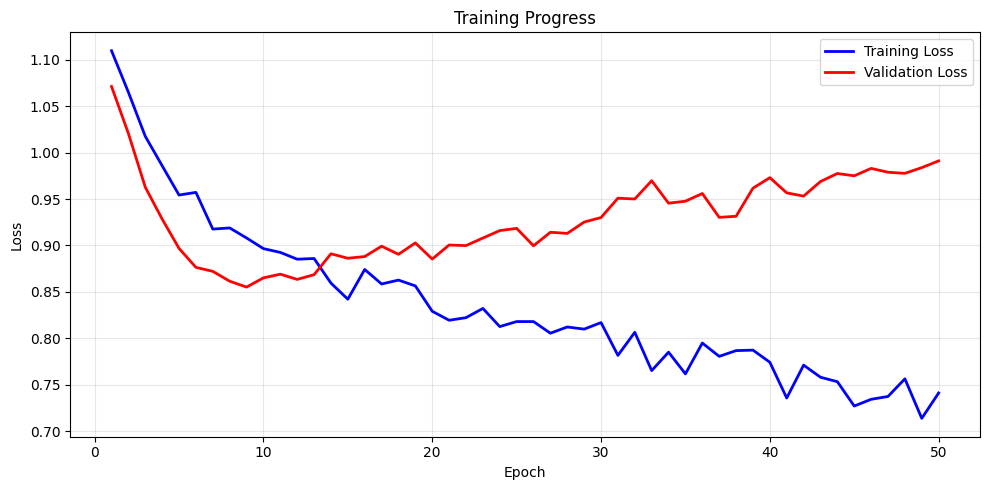

Final Train Loss: 0.7410
Final Val Loss: 0.9912


In [11]:
# Plot training curves
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

Temperature scaling

In [12]:
from scipy.optimize import minimize_scalar
from sklearn.metrics import log_loss

def find_best_temperature(model, val_dl):
    """Find optimal temperature for probability calibration"""
    model.eval()
    all_logits, all_labels = [], []

    with torch.no_grad():
        for xb, yb in val_dl:
            all_logits.append(model(xb))
            all_labels.append(yb)

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)

    uncalibrated_probs = torch.softmax(logits, 1)
    uncalibrated_loss = log_loss(labels.numpy(), uncalibrated_probs.numpy())

    def temperature_loss(T):
        scaled_probs = torch.softmax(logits / T, 1)
        return log_loss(labels.numpy(), scaled_probs.numpy())

    result = minimize_scalar(temperature_loss, bounds=(0.5, 3.0), method='bounded')
    optimal_T = result.x

    calibrated_probs = torch.softmax(logits / optimal_T, 1)
    calibrated_loss = log_loss(labels.numpy(), calibrated_probs.numpy())

    print(f"Optimal temperature: {optimal_T:.3f}")
    print(f"Log-loss before: {uncalibrated_loss:.4f} | after: {calibrated_loss:.4f}")

    return optimal_T

optimal_temp = find_best_temperature(model, val_dl)

Optimal temperature: 1.684
Log-loss before: 0.9912 | after: 0.9483


Evaluation

In [13]:
from sklearn.metrics import log_loss, classification_report

model.eval()
preds, true, probs_list = [], [], []

with torch.no_grad():
    for xb, yb in val_dl:
        logits = model(xb)
        p = logits.argmax(1)
        probs_list.extend(torch.softmax(logits, 1).numpy())
        preds.extend(p.numpy())
        true.extend(yb.numpy())

acc = accuracy_score(true, preds)
probs_array = np.vstack(probs_list)
probs_array = probs_array / probs_array.sum(axis=1, keepdims=True)
logloss = log_loss(true, probs_array)

baseline_preds = [0] * len(true)
baseline_acc = accuracy_score(true, baseline_preds)

print(f"Validation Accuracy: {acc:.3f}")
print(f"Baseline (always home): {baseline_acc:.3f}")
print(f"Log Loss: {logloss:.3f}")
print("\nClassification Report:")
print(classification_report(true, preds, target_names=["Home", "Away", "Draw"]))

Validation Accuracy: 0.539
Baseline (always home): 0.447
Log Loss: 0.991

Classification Report:
              precision    recall  f1-score   support

        Home       0.55      0.76      0.64        34
        Away       0.68      0.46      0.55        28
        Draw       0.20      0.14      0.17        14

    accuracy                           0.54        76
   macro avg       0.48      0.46      0.45        76
weighted avg       0.54      0.54      0.52        76



Calibration analysis

In [14]:
from sklearn.calibration import calibration_curve

print("Calibration Analysis:")
for i, outcome in enumerate(["Home", "Away", "Draw"]):
    y_binary = (np.array(true) == i).astype(int)
    prob_pred = probs_array[:, i]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_binary, prob_pred, n_bins=5, strategy='quantile'
    )
    print(f"{outcome}: predicted avg {prob_pred.mean():.3f}, actual rate {y_binary.mean():.3f}")

Calibration Analysis:
Home: predicted avg 0.474, actual rate 0.447
Away: predicted avg 0.285, actual rate 0.368
Draw: predicted avg 0.240, actual rate 0.184


Load current season data

In [15]:
data_25 = []
for m in get_matches(2025):
    data_25.append({
        "date": m["utcDate"],
        "home": m["homeTeam"]["name"],
        "away": m["awayTeam"]["name"],
        "hg": m["score"]["fullTime"]["home"],
        "ag": m["score"]["fullTime"]["away"],
        "status": m["status"]
    })

df25 = pd.DataFrame(data_25).sort_values("date").reset_index(drop=True)
played = df25[df25.status == "FINISHED"].copy()
future = df25[df25.status == "TIMED"].copy()

print(f"\nPlayed: {len(played)} | Future: {len(future)}")


Played: 210 | Future: 170


Feature prep for predictions

In [16]:
base_cols = ['date', 'home', 'away', 'hg', 'ag']
df_base = df[base_cols].copy()
played_base = played[base_cols].copy()

future_temp = future[['date', 'home', 'away']].copy()
future_temp['hg'] = 0
future_temp['ag'] = 0

all_games = pd.concat([df_base, played_base, future_temp], ignore_index=True)
all_games = teams_form_enhanced(all_games)

Add team strength

In [17]:
all_historical = pd.concat([df[base_cols], played_base], ignore_index=True)
all_games = add_team_strength(all_games, all_historical)

future_feat = all_games.iloc[-len(future):][feat].values
future_feat = sc.transform(future_feat)

Generate predictions

In [18]:
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(future_feat, dtype=torch.float32))
    probs = torch.softmax(logits / optimal_temp, 1).numpy()

Prediction summary

In [19]:
future["p_home"] = probs[:,0]
future["p_away"] = probs[:,1]
future["p_draw"] = probs[:,2]

print(f"Avg probabilities - Home: {future['p_home'].mean():.3f}, Away: {future['p_away'].mean():.3f}, Draw: {future['p_draw'].mean():.3f}")

Avg probabilities - Home: 0.483, Away: 0.415, Draw: 0.102


Monte Carlo simulation

In [20]:
teams = pd.unique(df25[["home","away"]].values.ravel())
points = {t:0 for t in teams}

for _, r in played.iterrows():
    if r.hg > r.ag: points[r.home] += 3
    elif r.hg < r.ag: points[r.away] += 3
    else:
        points[r.home] += 1
        points[r.away] += 1

def simulate():
    """Simulate remaining season with noise and momentum"""
    pts = points.copy()
    team_form = {t: 0 for t in teams}
    NOISE_STD = 0.20
    FORM_IMPACT = 0.05

    for _, r in future.iterrows():
        probs = np.array([r.p_home, r.p_away, r.p_draw])
        probs = probs / probs.sum()

        noise = np.random.normal(0, NOISE_STD, 3)
        probs[0] += team_form[r.home] * FORM_IMPACT
        probs[1] += team_form[r.away] * FORM_IMPACT
        probs = np.maximum(probs + noise, 0.05)
        probs = probs / probs.sum()

        res = np.random.choice([0, 1, 2], p=probs)

        if res == 0:
            pts[r.home] += 3
            team_form[r.home] = min(team_form[r.home] + 1, 3)
            team_form[r.away] = max(team_form[r.away] - 1, -3)
        elif res == 1:
            pts[r.away] += 3
            team_form[r.away] = min(team_form[r.away] + 1, 3)
            team_form[r.home] = max(team_form[r.home] - 1, -3)
        else:
            pts[r.home] += 1
            pts[r.away] += 1
            team_form[r.home] *= 0.5
            team_form[r.away] *= 0.5

    return pts

cumulative_points = {t: 0 for t in teams}
title_wins = {t: 0 for t in teams}

n_sims = 1000
print(f"Running {n_sims} simulations...")
for i in range(n_sims):
    sim_points = simulate()
    winner = max(sim_points, key=sim_points.get)
    title_wins[winner] += 1
    for team in teams:
        cumulative_points[team] += sim_points[team]

avg_points = {t: cumulative_points[t] / n_sims for t in teams}
print("Done")

Running 1000 simulations...
Done
Done


Final table

In [21]:

team_stats = {}
for team in teams:
    team_stats[team] = {
        'played': 0, 'wins': 0, 'draws': 0, 'losses': 0,
        'gf': 0, 'ga': 0
    }

for _, r in played.iterrows():
    team_stats[r.home]['played'] += 1
    team_stats[r.home]['gf'] += r.hg
    team_stats[r.home]['ga'] += r.ag

    team_stats[r.away]['played'] += 1
    team_stats[r.away]['gf'] += r.ag
    team_stats[r.away]['ga'] += r.hg

    if r.hg > r.ag:
        team_stats[r.home]['wins'] += 1
        team_stats[r.away]['losses'] += 1
    elif r.hg < r.ag:
        team_stats[r.away]['wins'] += 1
        team_stats[r.home]['losses'] += 1
    else:
        team_stats[r.home]['draws'] += 1
        team_stats[r.away]['draws'] += 1

results_df = pd.DataFrame({
    'Team': teams,
    'P': [team_stats[t]['played'] for t in teams],
    'W': [team_stats[t]['wins'] for t in teams],
    'D': [team_stats[t]['draws'] for t in teams],
    'L': [team_stats[t]['losses'] for t in teams],
    'GF': [team_stats[t]['gf'] for t in teams],
    'GA': [team_stats[t]['ga'] for t in teams],
    'GD': [team_stats[t]['gf'] - team_stats[t]['ga'] for t in teams],
    'Curr': [points[t] for t in teams],
    'Proj': [avg_points[t] for t in teams],
    'Title%': [title_wins[t] / n_sims * 100 for t in teams]
}).sort_values('Proj', ascending=False).reset_index(drop=True)

results_df.index = results_df.index + 1

print("\n" + "="*110)
print("PREDICTED FINAL PREMIER LEAGUE TABLE 2025/26")
print("="*110)
print(results_df.to_string(index=True, float_format=lambda x: f'{x:.1f}'))


PREDICTED FINAL PREMIER LEAGUE TABLE 2025/26
                          Team   P   W  D   L   GF   GA    GD  Curr  Proj  Title%
1                   Arsenal FC  21  15  4   2 40.0 14.0  26.0    49  81.0    72.3
2               Aston Villa FC  21  13  4   4 33.0 24.0   9.0    43  72.8    13.4
3           Manchester City FC  21  13  4   4 45.0 19.0  26.0    43  72.6    13.8
4                 Liverpool FC  21  10  5   6 32.0 28.0   4.0    35  61.4     0.2
5                   Chelsea FC  21   8  7   6 34.0 24.0  10.0    31  56.2     0.0
6                 Brentford FC  21  10  3   8 35.0 28.0   7.0    33  55.5     0.1
7               Sunderland AFC  21   7  9   5 21.0 22.0  -1.0    30  55.4     0.1
8         Manchester United FC  21   8  8   5 36.0 32.0   4.0    32  54.5     0.0
9    Brighton & Hove Albion FC  21   7  8   6 31.0 28.0   3.0    29  53.5     0.1
10                   Fulham FC  21   9  4   8 30.0 30.0   0.0    31  53.0     0.0
11        Tottenham Hotspur FC  21   7  6   8 30.0 2

Save outputs

In [22]:
import os
import json
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

output_dir = '../outputs'
os.makedirs(output_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("Saving outputs")

# Predicted table
results_df.to_csv(f'{output_dir}/predicted_table_{timestamp}.csv', index=True)

# Metrics
metrics = {
    'timestamp': timestamp,
    'accuracy': float(acc),
    'log_loss': float(logloss),
    'baseline_accuracy': float(baseline_acc),
    'temperature': float(optimal_temp),
    'n_simulations': n_sims
}
with open(f'{output_dir}/metrics_{timestamp}.json', 'w') as f:
    json.dump(metrics, f, indent=2)

# Confusion matrix
cm = confusion_matrix(true, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Home', 'Away', 'Draw'],
            yticklabels=['Home', 'Away', 'Draw'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(f'{output_dir}/confusion_matrix_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.close()

# Calibration plot
plt.figure(figsize=(10, 6))
for i, outcome in enumerate(["Home", "Away", "Draw"]):
    y_bin = (np.array(true) == i).astype(int)
    frac, mean_pred = calibration_curve(y_bin, probs_array[:, i], n_bins=5, strategy='quantile')
    plt.plot(mean_pred, frac, 'o-', label=outcome)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Frequency')
plt.title('Calibration Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/calibration_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"Saved to {output_dir}/ : table, metrics, confusion matrix, calibration")

Saving outputs
Saved to ../outputs/ : table, metrics, confusion matrix, calibration
Saved to ../outputs/ : table, metrics, confusion matrix, calibration
